# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
 -1
 -1
 -1
 -1
  1
 -1
  1
 -1
  1
  ⋮
  1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

### We create a function to visualize the data

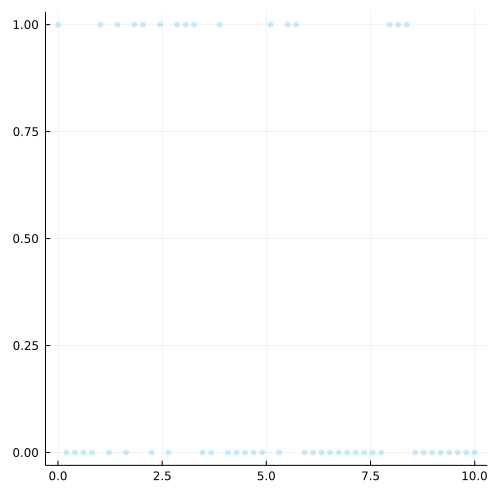

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.886336 seconds (1.86 M allocations: 98.379 MiB, 99.51% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.8478499862304473, 0.8383059158007921, 0.822475815897547, 0.7932438372502219, 0.7482602074073855, 0.6926228684166489, 0.6394324387151092, 0.6056030372682639, 0.603109236382527, 0.6291626974517275  …  0.8363559847521946, 0.8553744803245037, 0.9188752085981158, 1.0200008289276326, 1.142738431347978, 1.264323013670326, 1.3623115762954723, 1.4207287771578232, 1.4332066718027752, 1.4031680534652566], θ = [0.2360275247651586, 0.2363198191028643, 0.2367992231035234, 0.23766641700238386, 0.23895362494527703, 0.2404629564974681, 0.24181624511702796, 0.24262947036863097, 0.24268792301648784, 0.2420670881572262  …  0.23637923717089387, 0.23579537421251245, 0.23377806286008931, 0.2303652646817726, 0.2259327737380618, 0.22127999708233365, 0.21737694793296922, 0.2149971515769628, 0.2144843913793297,

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:22
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:13
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:29
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:06
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:26
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:23
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:21
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.06026630847828757, 0.16765748730400853, 0.3501484809091335, 0.43081618698186264, 0.44256845955840085, 0.4456551633632636, 0.426136663025811, 0.4448618748091946, 0.4735818286628586, 0.521369220004698  …  -0.01146036317446708, -0.023051052272758832, -0.09880154630669113, -0.19055176480877167, -0.2719677258899056, -0.277420472556958, -0.29447558608286806, -0.1625210884886299, -0.006847451642955971, 0.23309536112263296]]
 [[-0.8106823740942619, -1.0898681314179222, -1.2214230003038917, -1.2529708585541774, -1.1675044598996895, -0.9946183859762485, -0.8336174880987504, -0.6713144331895768, -0.5657233803331285, -0.5160465754306276  …  0.33144453533071805, 0.14549278474612115, -0.17011551683772969, -0.5358207845197586, -0.9114719722851058, -1.2082996331288895, -1.340205262461956, -1.294379697632911, -1.0882244076868133, -0.7221415837284495]]
 [[-0.6550940928591942, -0.5694946601940848, -0.5820571453323091, -0.6736542020657887, -0.85515361806

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

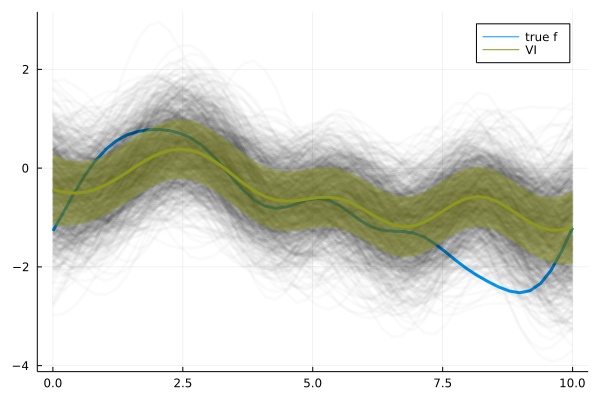

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

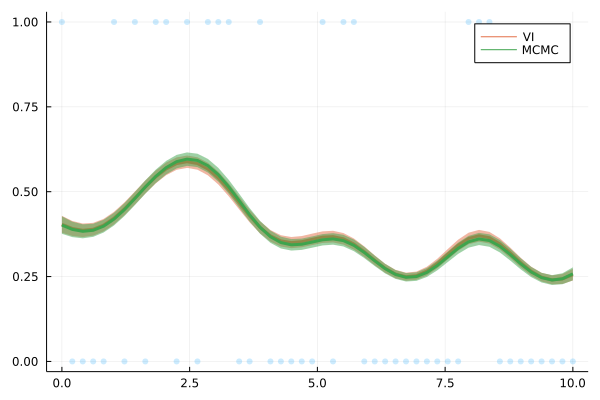

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*